In [1]:
# Colab setup

# from google.colab import drive
# drive.mount("/content/drive/")

# %cd "/content/drive/MyDrive/PACS/APSC_project (do not delete!)/bayesian_network/examples/1_darcy_flow"

# try:
#     from dlroms import *
# except:
#     !pip install git+https://github.com/NicolaRFranco/dlroms.git
#     from dlroms import *

In [2]:
from dlroms import *
from dlroms.dnns import *
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from IPython.display import clear_output as clc
import sys

# Setup

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
# Domain, mesh, and function space definition

domain = fe.rectangle((0.0, 0.0), (1.0, 1.0))

mesh_C = fe.mesh(domain, stepsize=0.05)
mesh_H = fe.mesh(domain, stepsize=0.02)

V_C = fe.space(mesh_C, 'CG', 1) # 441 dofs
V_H = fe.space(mesh_H, 'CG', 1) # 2601 dofs

l2_C = L2(V_C) # L2 norm
l2_H = L2(V_H)

if torch.cuda.is_available():
    l2_C.cuda()
    l2_H.cuda()

clc()

In [5]:
# Load train and test data

path_train_C = os.path.join(os.getcwd(), "snapshots", "snapshots_train_C.npz")
data_train_C = np.load(path_train_C)

N_train_C = data_train_C['K'].shape[0]
K_train_C = torch.tensor(data_train_C['K'].astype(np.float32)).to(device)
p_train_C = torch.tensor(data_train_C['p'].astype(np.float32)).to(device)
u_x_train_C = torch.tensor(data_train_C['u_x'].astype(np.float32)).to(device)
u_y_train_C = torch.tensor(data_train_C['u_y'].astype(np.float32)).to(device)

path_test_C = os.path.join(os.getcwd(), "snapshots", "snapshots_test_C.npz")
data_test_C = np.load(path_test_C)

N_test_C = data_test_C['K'].shape[0]
K_test_C = torch.tensor(data_test_C['K'].astype(np.float32)).to(device)
p_test_C = torch.tensor(data_test_C['p'].astype(np.float32)).to(device)
u_x_test_C = torch.tensor(data_test_C['u_x'].astype(np.float32)).to(device)
u_y_test_C = torch.tensor(data_test_C['u_y'].astype(np.float32)).to(device)

path_train_H = os.path.join(os.getcwd(), "snapshots", "snapshots_train_H.npz")
data_train_H = np.load(path_train_H)

N_train_H = data_train_H['K'].shape[0]
K_train_H = torch.tensor(data_train_H['K'].astype(np.float32)).to(device)
p_train_H = torch.tensor(data_train_H['p'].astype(np.float32)).to(device)
u_x_train_H = torch.tensor(data_train_H['u_x'].astype(np.float32)).to(device)
u_y_train_H = torch.tensor(data_train_H['u_y'].astype(np.float32)).to(device)

path_test_H = os.path.join(os.getcwd(), "snapshots", "snapshots_test_H.npz")
data_test_H = np.load(path_test_H)

N_test_H = data_test_H['K'].shape[0]
K_test_H = torch.tensor(data_test_H['K'].astype(np.float32)).to(device)
p_test_H = torch.tensor(data_test_H['p'].astype(np.float32)).to(device)
u_x_test_H = torch.tensor(data_test_H['u_x'].astype(np.float32)).to(device)
u_y_test_H = torch.tensor(data_test_H['u_y'].astype(np.float32)).to(device)

# Neural network cores

In [ ]:
m = 16

# Encoder
psi = Reshape(1, 21, 21) + \
      Conv2D(6, (1, m), stride=1, activation=torch.tanh) + \
      Conv2D(7, (m, 2 * m), stride=1, activation=torch.tanh) + \
      Conv2D(7, (2 * m, 4 * m), stride=1, activation=None)

# Decoder
psi_prime = Deconv2D(7, (4 * m, 2 * m), stride=1, activation=torch.tanh) + \
            Deconv2D(7, (2 * m, m), stride=1, activation=torch.tanh) + \
            Deconv2D(6, (m, 1), stride=1, activation=None) + \
            Reshape(-1)

# Mesh-informed layers
layer_in = Local(V_H, V_C, support=0.05, activation=None)
layer_out = Local(V_C, V_H, support=0.05, activation=None)

print("Encoder trainable parameters:", psi.dof())
print("Decoder trainable parameters:", psi_prime.dof())
print("Input mesh-informed layer trainable parameters:", layer_in.dof())
print("Output mesh-informed layer trainable parameters:", layer_out.dof())

# Pressure network

In [ ]:
# Train encoder-decoder network for pressure

p_model = DFNN(psi, psi_prime)
p_model.He()

if torch.cuda.is_available():
    p_model.cuda()

p_model.train(K_train_C, p_train_C, ntrain=N_train_C, epochs=200, loss=mse(l2_C), verbose=True)

In [ ]:
# From low fidelity to high fidelity data with mesh-informed layer

p_model.freeze() # freeze the weights of the trained encoder-decoder network

layer_in.He() # reset weights
layer_out.He()

p_model_refined = DFNN(layer_in, p_model, layer_out)

if torch.cuda.is_available():
	p_model_refined.cuda()

In [ ]:
p_model_refined.train(K_train_H, p_train_H, ntrain=N_train_H, epochs=100, loss=mse(l2_H), verbose=True)

In [49]:
# Generate predictions

with torch.no_grad():
    p_pred_train = p_model(K_train_C)
    p_pred = p_model(K_test_C)
    p_pred_train_refined = p_model_refined(K_train_H)
    p_pred_refined = p_model_refined(K_test_H)

In [ ]:
# Check integral of p

print(torch.mean(p_pred_train))
print(torch.mean(p_pred))
print(torch.mean(p_pred_train_refined))
print(torch.mean(p_pred_refined))

In [51]:
# Compute relative error

error_train = mre(l2_C)(p_train_C, p_pred_train)
error_test = mre(l2_C)(p_test_C, p_pred)
error_train_refined = mre(l2_H)(p_train_H, p_pred_train_refined)
error_test_refined = mre(l2_H)(p_test_H, p_pred_refined)
print('Relative training error: {:.2f}%'.format(100 * torch.mean(error_train)))
print('Relative test error: {:.2f}%'.format(100 * torch.mean(error_test)))
print('Relative training error (refined): {:.2f}%'.format(100 * torch.mean(error_train_refined)))
print('Relative test error (refined): {:.2f}%'.format(100 * torch.mean(error_test_refined)))

Relative training error: 6.26%
Relative test error: 7.37%
Relative training error (refined): 6.30%
Relative test error (refined): 6.95%


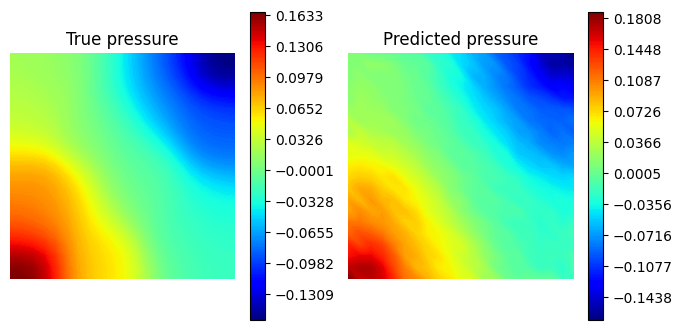

In [52]:
idx = 50

plt.figure(figsize=(8, 5))

plt.subplot(1, 2, 1)
fe.plot(p_test_C[idx], V_C, cmap='jet', colorbar=True)
plt.title("True pressure")

plt.subplot(1, 2, 2)
fe.plot(p_pred[idx], V_C, cmap='jet', colorbar=True)
plt.title("Predicted pressure")

plt.show()

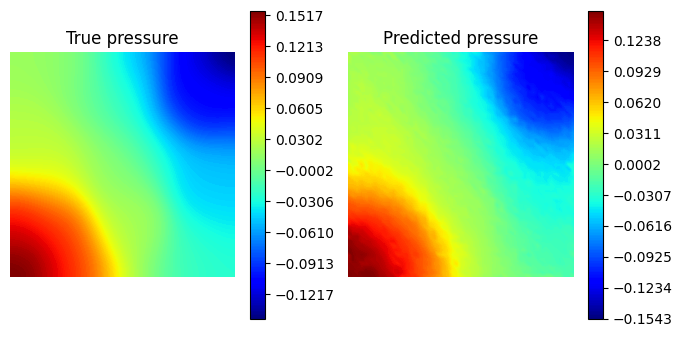

In [53]:
idx = 50

plt.figure(figsize=(8, 5))

plt.subplot(1, 2, 1)
fe.plot(p_test_H[idx], V_H, cmap='jet', colorbar=True)
plt.title("True pressure (refined)")

plt.subplot(1, 2, 2)
fe.plot(p_pred_refined[idx], V_H, cmap='jet', colorbar=True)
plt.title("Predicted pressure (refined)")

plt.show()

In [54]:
# Save trained model

checkpoint_dir = 'checkpoints'

if not os.path.exists(checkpoint_dir):
		os.makedirs(checkpoint_dir)

torch.save(p_model.state_dict(), os.path.join(checkpoint_dir, 'p_model_C.pth'))
torch.save(p_model_refined.state_dict(), os.path.join(checkpoint_dir, 'p_model_H.pth'))

# Velocity network (x-component)

In [ ]:
# Train encoder-decoder network for velocity (x-component)

u_x_model = DFNN(psi, psi_prime)
u_x_model.He()

if torch.cuda.is_available():
	  u_x_model.cuda()

u_x_model.train(K_train_C, u_x_train_C, ntrain=N_train_C, epochs=200, loss=mse(l2_C), verbose=True)

In [ ]:
# From low fidelity to high fidelity data with mesh-informed layer

u_x_model.freeze()

layer_in.He()
layer_out.He()

u_x_model_refined = DFNN(layer_in, u_x_model, layer_out)

if torch.cuda.is_available():
    u_x_model_refined.cuda()

u_x_model_refined.train(K_train_H, u_x_train_H, ntrain=N_train_H, epochs=100, loss=mse(l2_H), verbose=True)

In [ ]:
# Generate predictions

with torch.no_grad():
    u_x_pred_train = u_x_model(K_train_C)
    u_x_pred = u_x_model(K_test_C)
    u_x_pred_train_refined = u_x_model_refined(K_train_H)
    u_x_pred_refined = u_x_model_refined(K_test_H)

In [ ]:
# Compute relative error

error_train = mre(l2_C)(u_x_train_C, u_x_pred_train)
error_test = mre(l2_C)(u_x_test_C, u_x_pred)
error_train_refined = mre(l2_H)(u_x_train_H, u_x_pred_train_refined)
error_test_refined = mre(l2_H)(u_x_test_H, u_x_pred_refined)

print('Relative training error: {:.2f}%'.format(100 * torch.mean(error_train)))
print('Relative test error: {:.2f}%'.format(100 * torch.mean(error_test)))
print('Relative training error (refined): {:.2f}%'.format(100 * torch.mean(error_train_refined)))
print('Relative test error (refined): {:.2f}%'.format(100 * torch.mean(error_test_refined)))

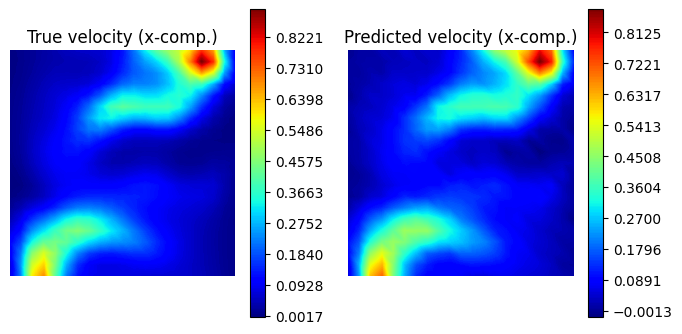

In [61]:
idx = 90

plt.figure(figsize=(8, 5))

plt.subplot(1, 2, 1)
fe.plot(u_x_test_C[idx], V_C, cmap='jet', colorbar=True)
plt.title("True velocity (x-comp.)")

plt.subplot(1, 2, 2)
fe.plot(u_x_pred[idx], V_C, cmap='jet', colorbar=True)
plt.title("Predicted velocity (x-comp.)")

plt.show()

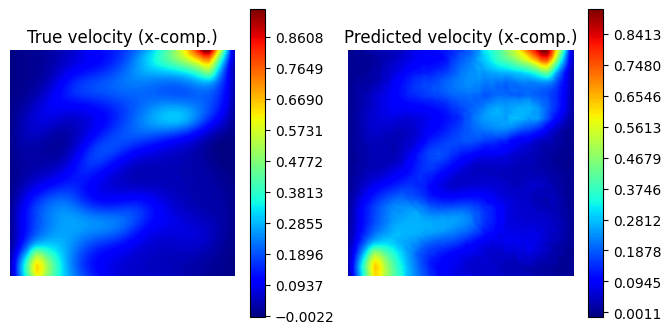

In [62]:
idx = 90

plt.figure(figsize=(8, 5))

plt.subplot(1, 2, 1)
fe.plot(u_x_test_H[idx], V_H, cmap='jet', colorbar=True)
plt.title("True velocity (x-comp., refined)")

plt.subplot(1, 2, 2)
fe.plot(u_x_pred_refined[idx], V_H, cmap='jet', colorbar=True)
plt.title("Predicted velocity (x-comp., refined)")

plt.show()

In [ ]:
# Save trained model

checkpoint_dir = 'checkpoints'

if not os.path.exists(checkpoint_dir):
	os.makedirs(checkpoint_dir)

torch.save(u_x_model.state_dict(), os.path.join(checkpoint_dir, 'u_x_model_C.pth'))
torch.save(u_x_model_refined.state_dict(), os.path.join(checkpoint_dir, 'u_x_model_H.pth'))

# Velocity network (y-component)

In [ ]:
# Train encoder-decoder network for velocity (y-component)

u_y_model = DFNN(psi, psi_prime)
u_y_model.He()

if torch.cuda.is_available():
	u_y_model.cuda()

u_y_model.train(K_train_C, u_y_train_C, ntrain=N_train_C, epochs=200, loss=mse(l2_C), verbose=True)

In [ ]:
# From low fidelity to high fidelity data with mesh-informed layer

u_y_model.freeze()

layer_in.He()
layer_out.He()

u_y_model_refined = DFNN(layer_in, u_y_model, layer_out)

if torch.cuda.is_available():
		u_y_model_refined.cuda()

u_y_model_refined.train(K_train_H, u_y_train_H, ntrain=N_train_H, epochs=100, loss=mse(l2_H), verbose=True)

In [69]:
# Generate predictions

with torch.no_grad():
    u_y_pred_train = u_y_model(K_train_C)
    u_y_pred = u_y_model(K_test_C)
    u_y_pred_train_refined = u_y_model_refined(K_train_H)
    u_y_pred_refined = u_y_model_refined(K_test_H)

In [ ]:
# Compute relative error

error_train = mre(l2_C)(u_y_train_C, u_y_pred_train)
error_test = mre(l2_C)(u_y_test_C, u_y_pred)
error_train_refined = mre(l2_H)(u_y_train_H, u_y_pred_train_refined)
error_test_refined = mre(l2_H)(u_y_test_H, u_y_pred_refined)

print('Relative training error: {:.2f}%'.format(100 * torch.mean(error_train)))
print('Relative test error: {:.2f}%'.format(100 * torch.mean(error_test)))
print('Relative training error (refined): {:.2f}%'.format(100 * torch.mean(error_train_refined)))
print('Relative test error (refined): {:.2f}%'.format(100 * torch.mean(error_test_refined)))

In [ ]:
idx = 90

plt.figure(figsize=(8, 5))

plt.subplot(1, 2, 1)
fe.plot(u_y_test_C[idx], V_C, cmap='jet', colorbar=True)
plt.title("True velocity (y-comp.)")

plt.subplot(1, 2, 2)
fe.plot(u_y_pred[idx], V_C, cmap='jet', colorbar=True)
plt.title("Predicted velocity (y-comp.)")

plt.show()

In [ ]:
idx = 90

plt.figure(figsize=(8, 5))

plt.subplot(1, 2, 1)
fe.plot(u_y_test_H[idx], V_H, cmap='jet', colorbar=True)
plt.title("True velocity (y-comp., refined)")

plt.subplot(1, 2, 2)
fe.plot(u_y_pred_refined[idx], V_H, cmap='jet', colorbar=True)
plt.title("Predicted velocity (y-comp., refined)")

plt.show()

In [71]:
# Save trained model

checkpoint_dir = 'checkpoints'

if not os.path.exists(checkpoint_dir):
	os.makedirs(checkpoint_dir)

torch.save(u_y_model.state_dict(), os.path.join(checkpoint_dir, 'u_y_model_C.pth'))
torch.save(u_y_model_refined.state_dict(), os.path.join(checkpoint_dir, 'u_y_model_H.pth'))